In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# coding=utf-8
from __future__ import absolute_import, division, print_function

import logging
import argparse
import os
import random
import numpy as np
import time

from datetime import timedelta

import torch
import torch.distributed as dist

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from apex import amp
from apex.parallel import DistributedDataParallel as DDP

from models.modeling import VisionTransformer, CONFIGS
from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import get_world_size

from PIL import Image
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import pickle

from torchvision import transforms
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

from utils.dataset import CUB, CarsDataset, NABirds, dogs, INat2017
from utils.autoaugment import AutoAugImageNetPolicy

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def reduce_mean(tensor, nprocs):
    rt = tensor.clone()
    #dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= nprocs
    return rt

def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def visualize_scatter_with_images(tsne_vec, images, save_path = None, figsize=(100,50), image_zoom=3):
    fig, ax = plt.subplots(figsize=figsize)
    for c, (xy, i) in enumerate(zip(tsne_vec, images)):
        x0, y0 = xy
        if c == 0:
            print("Size of one image: ", i.shape)
        if i.shape[0] == 1:
            img = OffsetImage(i,zoom=image_zoom, cmap="gray")
        else:
             img = OffsetImage(i,zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.set_axis_off()
    ax.update_datalim(tsne_vec)
    ax.autoscale()
    if save_path is not None:
        fig.savefig(save_path)

def visualize_scatter_with_points(tsne_vec, labels, colors, save_path = None, figsize=(8,4)):
    plt.figure(figsize=figsize, facecolor='white')
    
    unique = list(set(labels))
    for i, u in enumerate(unique):
        xi = [tsne_vec[j,0] for j  in range(tsne_vec.shape[0]) if labels[j] == u]
        yi = [tsne_vec[j,1] for j  in range(tsne_vec.shape[0]) if labels[j] == u]
        plt.scatter(xi, yi, c=colors[i], label=str(u))
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8',
          '#f58231', '#42d4f4', '#f032e6', '#fabed4',
          '#469990', '#dcbeff', '#9A6324', '#fffac8',
          '#800000', '#aaffc3', '#000075', '#a9a9a9']

In [3]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

In [8]:
# setup
model_type = 'ViT-B_32'
name = 'serif_' + model_type.split('-')[-1] + '_long_checkpoint.bin'
pretrained_dir = os.path.join('./pretrained_ViT', model_type + '.npz')
pretrained_model = os.path.join('./output', name)
dataset = 'CUB_200_2011'
isTrain = True

# fixed params
data_root = 'dataset'
split = 'overlap'
slide_step = 12
num_classes = 4
img_size = 448
smoothing_value = 0.0
local_rank = -1
data_root = '{}/{}'.format(data_root, dataset)
train_batch_size = 4
eval_batch_size = 16
nprocs = 1

# pickle name
folder = 'saved_features'
if isTrain:
    data_type = 'train'
else:
    data_type = 'test'
filename = 'TransFG_{}_{}_{}'.format(model_type, dataset, data_type)

In [14]:
test_transform=transforms.Compose([transforms.Resize((600, 600), Image.BILINEAR),
                                   transforms.CenterCrop((448, 448)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

testset = CUB(root=data_root, is_train=isTrain, transform=test_transform)
test_sampler = SequentialSampler(testset) if local_rank == -1 else DistributedSampler(testset)

test_loader = DataLoader(testset,
                         sampler=test_sampler,
                         batch_size=eval_batch_size,
                         num_workers=4,
                         pin_memory=True) if testset is not None else None

In [5]:
# Prepare model
config = CONFIGS[model_type]
config.split = split
config.slide_step = slide_step

model = VisionTransformer(config, img_size, zero_head=True, num_classes=num_classes,
                          smoothing_value=smoothing_value)

model.load_from(np.load(pretrained_dir))

if pretrained_model is not None:
    pretrained_model = torch.load(pretrained_model)['model']
    model.load_state_dict(pretrained_model)
model.to(device);

load_pretrained: resized variant: torch.Size([1, 50, 768]) to torch.Size([1, 1226, 768])
load_pretrained: grid-size from 7 to 35


In [7]:
def get_features(model, testset, test_loader):
    samples = len(testset)
    count = 0
    
    images_array = np.zeros((samples, 448, 448), bool)
    labels_array = np.zeros(samples, np.int8)
    features_array = np.zeros((samples, 768), np.float32)

    model.eval()
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... ",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=local_rank not in [-1, 0])

    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(device) for t in batch)
        x, y = batch
        with torch.no_grad():
            output_vector = None

            def feature_hook(module, input_, output):
                nonlocal output_vector
                output_vector = input_

            a_hook = model.part_head.register_forward_hook(feature_hook)
            logits = model(x)
            a_hook.remove()
            
            images = x.detach().cpu().numpy()
            mins = images.min(axis=(1,2,3), keepdims=True)
            maxs = images.max(axis=(1,2,3), keepdims=True)
            norm_data = (images-mins)/(maxs-mins)
            norm_data = norm_data>0.5
            norm_data = norm_data.all(axis=1)
            
            features = output_vector[0].detach().cpu().numpy()
            
            images_array[count:count+norm_data.shape[0],:,:] = norm_data
            labels_array[count:count+norm_data.shape[0]] = y.detach().cpu().numpy()
            features_array[count:count+features.shape[0],:] = features
            count += images.shape[0]

        epoch_iterator.set_description("Validating... ")

    return images_array, labels_array, features_array

In [ ]:
images, labels, features = get_features(model, testset, test_loader)

Validating... :  82%|| 86/105 [01:38<00:21,  1.15s/it]

In [ ]:
out = dict()
out['images'] = images
out['labels'] = labels
out['features'] = features

save_obj(out, os.path.join(folder, filename))

In [9]:
out = load_obj(os.path.join(folder, filename))

images = out['images']
labels = out['labels']
features = out['features']

CLASSES = ['linear', 'slab', 'sans', 'triangular']
labels_class = [CLASSES[i] for i in labels]
img_colors = list(set([colors[i] for i in labels]))

In [10]:
tsne = TSNE(n_jobs = -1)
reduced = tsne.fit_transform(features)

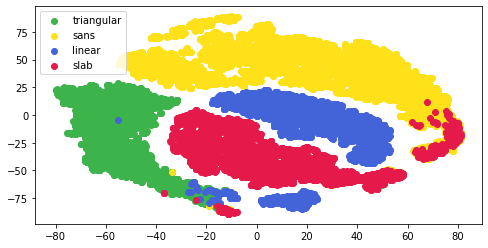

In [11]:
visualize_scatter_with_points(reduced, labels_class, img_colors)

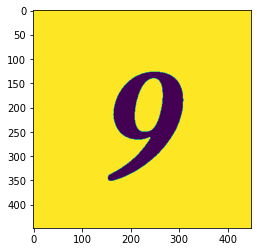

In [16]:
plt.imshow(images[123])